In [ ]:
#export
import tempfile
from fastai2.basics import *
from fastai2.learner import Callback

In [ ]:
from nbdev.showdoc import *

In [ ]:
#default_exp callback.captum

# Captum
Captum is the Model Interpretation Library from PyTorch as available [here](https://captum.ai)

To use this we need to install the package using 

`conda install captum -c pytorch`

or 

`pip install captum`

This is a Call back to use Captum.

In [ ]:
#export
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
#export
class CaptumCallback(Callback):
    "Captum Callback for Resnet Interpretation"
    def __init__(self):
        pass

    def after_fit(self):
        self.integrated_gradients = IntegratedGradients(self.model)
        
    def visualize(self,inp_data,n_steps=200,cmap_name='custom blue',colors=None,N=256,methods=['original_image','heat_map'],signs=["all", "positive"],outlier_perc=1):
        dl = self.dls.test_dl([inp_data],with_labels=True, bs=1)
        self.enc_inp,self.enc_preds= dl.one_batch()
        dec_data=dl.decode((self.enc_inp,self.enc_preds))
        self.dec_img,self.dec_pred=dec_data[0][0],dec_data[1][0]
        self.colors = [(0, '#ffffff'),(0.25, '#000000'),(1, '#000000')] if colors is None else colors
        self.attributions_ig = self.integrated_gradients.attribute(self.enc_inp.to(self.dl.device), target=self.enc_preds, n_steps=200)
        default_cmap = LinearSegmentedColormap.from_list(cmap_name, 
                                                 self.colors, N=N)
        _ = viz.visualize_image_attr_multiple(np.transpose(self.attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(self.dec_img.numpy(), (1,2,0)),
                             methods=methods,
                             cmap=default_cmap,
                             show_colorbar=True,
                             signs=signs,
                             outlier_perc=outlier_perc, titles=[f'Original Image - ({self.dec_pred})', 'IG'])

In [ ]:
from fastai2.vision.all import *
path = untar_data(URLs.PETS)/'images'

def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(128))

learn = cnn_learner(dls, resnet34, metrics=error_rate,cbs=CaptumCallback())
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.361520,0.120785,0.052097,00:15


epoch,train_loss,valid_loss,error_rate,time
0,0.155066,0.064784,0.024357,00:15


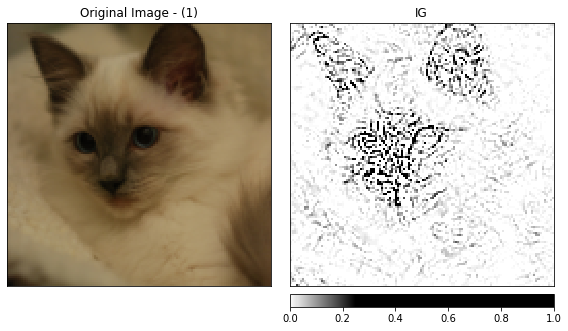

In [ ]:
paths=list(path.iterdir())
index=random.randint(0,len(paths))
image_path=paths[index]

learn.captum.visualize(image_path,n_steps=1000)